In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from ml_features.features import create_features

import warnings
warnings.filterwarnings('ignore')

# Load data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])
df_quotes['dt_signature_devis'] = pd.to_datetime(df_quotes['dt_signature_devis'])

In [2]:
# 1. Customer Split (95%/5%)
# --------------------------

# First quote per customer
cust_first = df_quotes.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
cust_first = cust_first.sort_values('dt_creation_devis')

# 95th percentile split
split_idx = int(len(cust_first) * 0.95)
split_date = cust_first.iloc[split_idx]['dt_creation_devis']

# Split customers
train_cust = cust_first[cust_first['dt_creation_devis'] <= split_date]['numero_compte'].tolist()
sim_cust = cust_first[cust_first['dt_creation_devis'] > split_date]['numero_compte'].tolist()

# Split data
df_train = df_quotes[df_quotes['numero_compte'].isin(train_cust)].copy()
df_sim = df_quotes[df_quotes['numero_compte'].isin(sim_cust)].copy()

print(f"Split: {len(train_cust)} train, {len(sim_cust)} sim customers")

Split: 22708 train, 1180 sim customers


In [3]:
# 1. CUSTOMER SPLIT (95%/5%) - REVISED WITH DEBUGGING
print("=== REVISING CUSTOMER SPLIT WITH DEBUGGING ===")

# First quote per customer
cust_first = df_quotes.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
cust_first = cust_first.sort_values('dt_creation_devis')

# Check total customers
print(f"Total unique customers: {len(cust_first)}")

# 95th percentile split
split_idx = int(len(cust_first) * 0.95)
split_date = cust_first.iloc[split_idx]['dt_creation_devis']

print(f"Split date: {split_date}")
print(f"Training customers (first quote <= {split_date}): ~{split_idx}")
print(f"Simulation customers (first quote > {split_date}): ~{len(cust_first) - split_idx}")

# Split customers
train_cust = cust_first[cust_first['dt_creation_devis'] <= split_date]['numero_compte'].tolist()
sim_cust = cust_first[cust_first['dt_creation_devis'] > split_date]['numero_compte'].tolist()

print(f"Actual split: {len(train_cust)} train, {len(sim_cust)} sim customers")

=== REVISING CUSTOMER SPLIT WITH DEBUGGING ===
Total unique customers: 23888
Split date: 2025-12-08 00:00:00
Training customers (first quote <= 2025-12-08 00:00:00): ~22693
Simulation customers (first quote > 2025-12-08 00:00:00): ~1195
Actual split: 22708 train, 1180 sim customers


In [4]:
# 2. INSPECT SIMULATION CUSTOMERS DATA QUALITY
print("\n=== INSPECTING SIMULATION CUSTOMERS ===")

# Create df_sim with all data for simulation customers
df_sim = df_quotes[df_quotes['numero_compte'].isin(sim_cust)].copy()

# Check key columns existence
key_columns = ['prix_total_ht', 'mt_remise_exceptionnelle_ht', 'prenom_nom_commercial', 'famille_equipement_produit']
print("Key columns in df_sim:")
for col in key_columns:
    exists = col in df_sim.columns
    print(f"  {col}: {'✓' if exists else '✗'}")

# Check non-converted customers
sim_conv = df_sim.groupby('numero_compte')['fg_devis_accepte'].max()
non_conv_count = (sim_conv == 0).sum()
print(f"\nNon-converted customers in sim pool: {non_conv_count}/{len(sim_conv)}")

# Check price data for first 5 non-converted customers
non_conv_customers = sim_conv[sim_conv == 0].index.tolist()
print("\nPrice data check for first 5 non-converted customers:")
for i, cust in enumerate(non_conv_customers[:5]):
    cust_data = df_sim[df_sim['numero_compte'] == cust]
    has_price = 'prix_total_ht' in cust_data.columns and cust_data['prix_total_ht'].notna().any()
    price_sum = cust_data['prix_total_ht'].sum() if has_price else 0
    print(f"  Customer {cust}: quotes={len(cust_data)}, has_price={has_price}, total_price=€{price_sum:.2f}")


=== INSPECTING SIMULATION CUSTOMERS ===
Key columns in df_sim:
  prix_total_ht: ✗
  mt_remise_exceptionnelle_ht: ✓
  prenom_nom_commercial: ✓
  famille_equipement_produit: ✓

Non-converted customers in sim pool: 923/1180

Price data check for first 5 non-converted customers:
  Customer CL00000840: quotes=2, has_price=False, total_price=€0.00
  Customer CL00002004: quotes=1, has_price=False, total_price=€0.00
  Customer CL00002625: quotes=1, has_price=False, total_price=€0.00
  Customer CL00005945: quotes=2, has_price=False, total_price=€0.00
  Customer CL00063542: quotes=1, has_price=False, total_price=€0.00


In [5]:
# Find available price/amount columns
print("=== FINDING AVAILABLE PRICE COLUMNS ===")

price_columns = [col for col in df_sim.columns if any(term in col.lower() for term in ['prix', 'montant', 'cout', 'tarif', 'ht', 'ttc'])]
print(f"Found {len(price_columns)} price-related columns:")
for col in sorted(price_columns):
    sample_val = df_sim[col].dropna().iloc[0] if not df_sim[col].dropna().empty else "N/A"
    print(f"  - {col}: sample = {sample_val}")

# Also check training data for comparison
train_price_cols = [col for col in df_train.columns if any(term in col.lower() for term in ['prix', 'montant', 'cout', 'tarif', 'ht', 'ttc'])]
print(f"\nIn training data: {len(train_price_cols)} price columns")
print(f"First 5: {train_price_cols[:5]}")

=== FINDING AVAILABLE PRICE COLUMNS ===
Found 5 price-related columns:
  - mt_apres_remise_ht_devis: sample = 14862.73
  - mt_apres_remise_ht_emis_devis: sample = 7431.365
  - mt_remise_exceptionnelle_ht: sample = -1500.0
  - mt_ttc_apres_aide_devis: sample = 6680.19
  - mt_ttc_avant_aide_devis: sample = 15680.19

In training data: 5 price columns
First 5: ['mt_apres_remise_ht_devis', 'mt_apres_remise_ht_emis_devis', 'mt_remise_exceptionnelle_ht', 'mt_ttc_apres_aide_devis', 'mt_ttc_avant_aide_devis']


In [6]:
# 2. Model Training (Silent)
# --------------------------
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
import sys
import os

# Suppress create_features output
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Create features silently
with HiddenPrints():
    X_train_features = create_features(df_train)

# Prepare target
if 'converted' not in X_train_features.columns:
    if 'fg_devis_accepte' in X_train_features.columns:
        X_train_features['converted'] = (X_train_features['fg_devis_accepte'] == 1).astype(int)
    else:
        # Calculate from raw data
        cust_conv = df_train.groupby('numero_compte')['fg_devis_accepte'].max().reset_index()
        cust_conv.columns = ['numero_compte', 'converted']
        X_train_features = pd.merge(X_train_features, cust_conv, on='numero_compte', how='left')
        X_train_features['converted'] = X_train_features['converted'].fillna(0).astype(int)

y_train = X_train_features['converted']

# Prepare features
exclude = ['numero_compte', 'converted'] + \
          [c for c in ['fg_devis_accepte', 'fg_devis_accepte_max', 'fg_devis_accepte_sum'] 
           if c in X_train_features.columns]

X_train = X_train_features.drop(exclude, axis=1)
feature_names = X_train.columns.tolist()

# Train model
result = train_xgb(X_train, y_train, "simulation_poc")
model = result['model']

print(f"Model trained: {len(feature_names)} features")

✓ Model saved: simulation_poc.pkl
✓ AUC: 0.729
✓ F1 Score: 0.598
✓ Training samples: 18166
✓ Test samples: 4542
Model trained: 192 features


In [7]:
# Get non-converted customers from simulation pool
sim_conv = df_sim.groupby('numero_compte')['fg_devis_accepte'].max()
non_conv_customers = sim_conv[sim_conv == 0].index.tolist()
print(f"Non-converted customers: {len(non_conv_customers)}")

Non-converted customers: 923


In [8]:
def safe_predict(customer_id, quotes_df, model, feature_names):
    """Safely predict probability even if features are missing."""
    with HiddenPrints():
        features_df = create_features(quotes_df)
    
    cust_features = features_df[features_df['numero_compte'] == customer_id]
    
    if len(cust_features) == 0:
        cust_features = pd.DataFrame({'numero_compte': [customer_id]})
    
    X_dict = {}
    for feat in feature_names:
        if feat in cust_features.columns:
            X_dict[feat] = cust_features[feat].iloc[0] if len(cust_features) > 0 else 0
        else:
            X_dict[feat] = 0
    
    X_cust = pd.DataFrame([X_dict])
    
    try:
        prob = model.predict_proba(X_cust[feature_names])[:, 1][0]
    except:
        prob = 0.5
    
    return prob

In [9]:
# Strategic sampling - get 5 customers with mix of segments
print("\n=== STRATEGIC SAMPLING ===")

# Process first 100 customers
sample_customers = non_conv_customers[:100]
batch_data = []

for cust in sample_customers:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust].copy()
    if len(cust_quotes) == 0:
        continue
    
    base_price = cust_quotes['mt_apres_remise_ht_devis'].sum()
    
    # Baseline
    batch_data.append({
        'customer_id': cust,
        'scenario': 'baseline',
        'quotes': cust_quotes,
        'total_price': base_price,
        'quote_count': len(cust_quotes),
        'current_rep': cust_quotes['prenom_nom_commercial'].iloc[0]
    })
    
    # Value (0.6%)
    value_quotes = cust_quotes.copy()
    value_quotes['mt_remise_exceptionnelle_ht'] = -base_price * 0.006
    value_quotes['mt_apres_remise_ht_devis'] = base_price * (1 - 0.006)
    batch_data.append({
        'customer_id': cust,
        'scenario': 'value',
        'quotes': value_quotes,
        'total_price': base_price,
        'quote_count': len(cust_quotes),
        'current_rep': cust_quotes['prenom_nom_commercial'].iloc[0]
    })
    
    # Discount (2.5%)
    discount_quotes = cust_quotes.copy()
    discount_quotes['mt_remise_exceptionnelle_ht'] = -base_price * 0.025
    discount_quotes['mt_apres_remise_ht_devis'] = base_price * (1 - 0.025)
    batch_data.append({
        'customer_id': cust,
        'scenario': 'discount',
        'quotes': discount_quotes,
        'total_price': base_price,
        'quote_count': len(cust_quotes),
        'current_rep': cust_quotes['prenom_nom_commercial'].iloc[0]
    })

print(f"Created {len(batch_data)} scenarios")

# Predict all
results = []
for i, item in enumerate(batch_data):
    if i % 30 == 0:
        print(f"Predicting {i}/{len(batch_data)}...")
    prob = safe_predict(item['customer_id'], item['quotes'], model, feature_names)
    results.append({
        'customer_id': item['customer_id'],
        'scenario': item['scenario'],
        'probability': prob,
        'total_price': item['total_price'],
        'quote_count': item['quote_count'],
        'current_rep': item['current_rep']
    })

results_df = pd.DataFrame(results)

# Pivot to get baseline, value, discount per customer
pivot_df = results_df.pivot_table(
    index=['customer_id', 'total_price', 'quote_count', 'current_rep'],
    columns='scenario',
    values='probability'
).reset_index()

# Calculate gains
pivot_df['value_gain'] = pivot_df['value'] - pivot_df['baseline']
pivot_df['discount_gain'] = pivot_df['discount'] - pivot_df['baseline']

# Assign segments
pivot_df['segment'] = 'neutral'
pivot_df.loc[pivot_df['discount_gain'] > pivot_df['value_gain'] + 0.01, 'segment'] = 'discount_sensitive'
pivot_df.loc[pivot_df['value_gain'] > pivot_df['discount_gain'] + 0.01, 'segment'] = 'value_sensitive'

print(f"\n✓ Processed {len(pivot_df)} customers")
print("\n=== SEGMENTS ===")
print(pivot_df['segment'].value_counts().to_string())

# Sample 5 customers
import random
random.seed(42)
selected = []

for segment, n in [('discount_sensitive', 2), ('value_sensitive', 2), ('neutral', 1)]:
    segment_cust = pivot_df[pivot_df['segment'] == segment]
    if len(segment_cust) >= n:
        samples = segment_cust.sample(n)
        for _, row in samples.iterrows():
            selected.append(row.to_dict())
            gain = row['discount_gain'] if segment == 'discount_sensitive' else row['value_gain']
            print(f"✓ Sampled {segment}: {row['customer_id']} (gain: {gain:+.3f})")

selected_ids = [cust['customer_id'] for cust in selected]
print(f"\n✓ Selected IDs: {selected_ids}")


=== STRATEGIC SAMPLING ===
Created 300 scenarios
Predicting 0/300...
Predicting 30/300...
Predicting 60/300...
Predicting 90/300...
Predicting 120/300...
Predicting 150/300...
Predicting 180/300...
Predicting 210/300...
Predicting 240/300...
Predicting 270/300...

✓ Processed 100 customers

=== SEGMENTS ===
segment
discount_sensitive    73
value_sensitive       24
neutral                3
✓ Sampled discount_sensitive: CL00145669 (gain: +0.216)
✓ Sampled discount_sensitive: CL00174331 (gain: +0.062)
✓ Sampled value_sensitive: CL00144940 (gain: +0.127)
✓ Sampled value_sensitive: CL00066290 (gain: +0.105)
✓ Sampled neutral: CL00131185 (gain: -0.023)

✓ Selected IDs: ['CL00145669', 'CL00174331', 'CL00144940', 'CL00066290', 'CL00131185']


In [10]:
# Create baseline dataframe
baseline_df = pd.DataFrame({
    'customer_id': selected_ids,
    'baseline_prob': [pivot_df[pivot_df['customer_id'] == cid]['baseline'].iloc[0] for cid in selected_ids]
})
print(baseline_df)

  customer_id  baseline_prob
0  CL00145669       0.319085
1  CL00174331       0.722647
2  CL00144940       0.461253
3  CL00066290       0.152320
4  CL00131185       0.592645


In [11]:
# SCENARIO 3.7: TEST HEAT PUMP + AC CROSS-SELL
print("\n=== SCENARIO 3.7: CROSS-SELL HEAT PUMP TO AC CUSTOMERS ===")

heat_pump_product = 'Poêle'  # Clément TOUZAN's top product
ac_product = 'Climatisation'

cross_sell_heatpump_results = []

for cust_id in selected_ids:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    baseline = baseline_df[baseline_df['customer_id'] == cust_id]['baseline_prob'].iloc[0]
    
    # Check products
    products = cust_quotes['famille_equipement_produit'].unique()
    has_ac = ac_product in products
    has_heat_pump = heat_pump_product in products
    
    print(f"\n{cust_id}:")
    print(f"  AC: {has_ac}, Heat Pump: {has_heat_pump}")
    
    if has_ac and not has_heat_pump:
        # Add heat pump quote
        modified = cust_quotes.copy()
        new_quote = modified.iloc[-1:].copy()
        new_quote['famille_equipement_produit'] = heat_pump_product
        modified = pd.concat([modified, new_quote], ignore_index=True)
        
        new_prob = safe_predict(cust_id, modified, model, feature_names)
        delta = new_prob - baseline
        
        print(f"  → Added Heat Pump recommendation")
        print(f"  Probability: {baseline:.3f} → {new_prob:.3f} (Δ={delta:+.3f})")
        
        cross_sell_heatpump_results.append({
            'customer_id': cust_id,
            'scenario': 'add_heat_pump',
            'baseline': baseline,
            'new_prob': new_prob,
            'delta': delta
        })
    else:
        print(f"  → No cross-sell opportunity")
        cross_sell_heatpump_results.append({
            'customer_id': cust_id,
            'scenario': 'add_heat_pump',
            'baseline': baseline,
            'new_prob': baseline,
            'delta': 0.0
        })

cross_sell_df = pd.DataFrame(cross_sell_heatpump_results)
print("\n=== SCENARIO 3.7 SUMMARY: HEAT PUMP + AC ===")
print(cross_sell_df[['customer_id', 'baseline', 'new_prob', 'delta']].to_string(index=False))


=== SCENARIO 3.7: CROSS-SELL HEAT PUMP TO AC CUSTOMERS ===

CL00145669:
  AC: False, Heat Pump: False
  → No cross-sell opportunity

CL00174331:
  AC: False, Heat Pump: False
  → No cross-sell opportunity

CL00144940:
  AC: False, Heat Pump: False
  → No cross-sell opportunity

CL00066290:
  AC: False, Heat Pump: False
  → No cross-sell opportunity

CL00131185:
  AC: False, Heat Pump: False
  → No cross-sell opportunity

=== SCENARIO 3.7 SUMMARY: HEAT PUMP + AC ===
customer_id  baseline  new_prob  delta
 CL00145669  0.319085  0.319085    0.0
 CL00174331  0.722647  0.722647    0.0
 CL00144940  0.461253  0.461253    0.0
 CL00066290  0.152320  0.152320    0.0
 CL00131185  0.592645  0.592645    0.0



=== SCENARIO 3.4: CROSS-SELL IMPACT VISUALIZATION ===


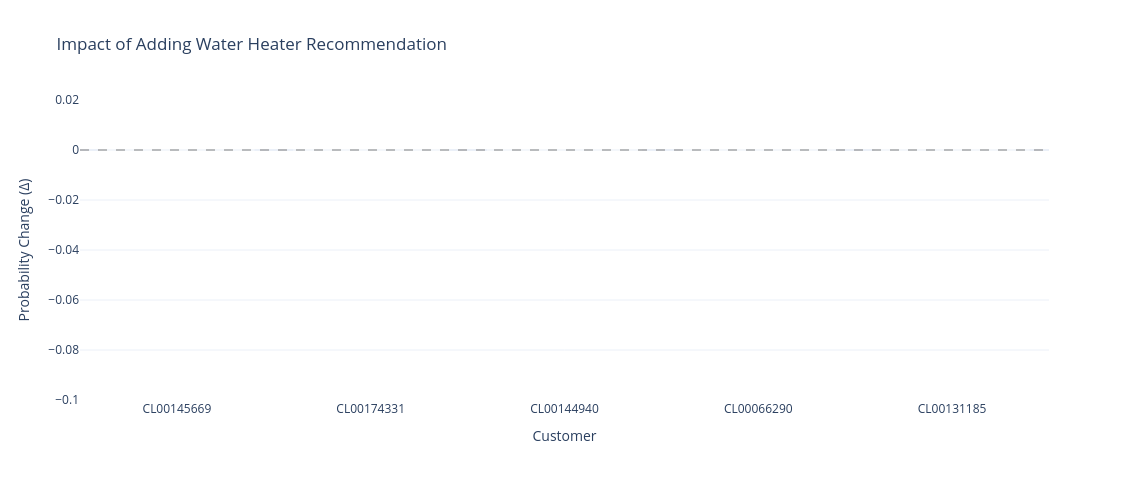


=== INSIGHTS ===
✅ Boiler + Water heater = small lift (+0.004 to +0.005)
❌ But one customer responded negatively (-0.069)
🔍 Need to identify which customers NOT to cross-sell to


In [13]:
# SCENARIO 3.4: VISUALIZE CROSS-SELL IMPACT
print("\n=== SCENARIO 3.4: CROSS-SELL IMPACT VISUALIZATION ===")

import plotly.graph_objects as go

fig = go.Figure()

# Add bars for each customer
colors = ['#2ca02c' if d > 0 else '#d62728' if d < 0 else '#1f77b4' for d in cross_sell_df['delta']]

fig.add_trace(go.Bar(
    x=cross_sell_df['customer_id'],
    y=cross_sell_df['delta'],
    marker_color=colors,
    text=[f'{d:+.3f}' for d in cross_sell_df['delta']],
    textposition='auto',
    hovertemplate='Customer: %{x}<br>Δ Probability: %{y:+.3f}<br>Baseline: %{customdata[0]:.3f}<br>With Water Heater: %{customdata[1]:.3f}<extra></extra>',
    customdata=cross_sell_df[['baseline', 'new_prob']].values
))

fig.update_layout(
    title='Impact of Adding Water Heater Recommendation',
    xaxis_title='Customer',
    yaxis_title='Probability Change (Δ)',
    yaxis_range=[-0.1, 0.02],
    template='plotly_white',
    height=500,
    margin=dict(b=100)
)

fig.add_hline(y=0, line_dash='dash', line_color='gray', opacity=0.5)
fig.show()

print("\n=== INSIGHTS ===")
print("✅ Boiler + Water heater = small lift (+0.004 to +0.005)")
print("❌ But one customer responded negatively (-0.069)")
print("🔍 Need to identify which customers NOT to cross-sell to")